<a href="https://colab.research.google.com/github/igquinteroch/deep-learning-coursework/blob/main/A1b_DL_TC5033_A01794419.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

## Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet).

While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

## Instructions

  This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances).
  
  While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell).
  
  Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

  * Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

  * Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

  * Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

  * Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
  * Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

  * Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

  * Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

## Evaluation Criteria

* Code Readability and Comments
* Appropriateness of chosen architecture and hyperparameters for the ASL dataset
* Performance of the model on the ASL dataset (at least 70% acc)
* Quality of Markdown documentation

## Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


### Import the libraries and set the stage


* `numpy`: Performs mathematical operations on large arrays or matrices.
* `string`: Provides utilities for string processing.
* `pandas`: Used for data manipulation.
* `matplotlib.pyplot`: Used for plotting data.
* `cv2`: Used for image processing.
* `os`: Allows interaction with the OS - e.g., directory navigation.

In [1]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

# Enabling autoreload in the Jupyter Notebook
%load_ext autoreload
%autoreload 2

# Show plots inline in the notebook
%matplotlib inline

# Provides access to the Drive from within the notebook
from google.colab import drive

# Mounts the Drive into the Colab environment
drive.mount("/content/drive")

# Changes the current working directory to the specified path in Google Drive.
os.chdir("/content/drive/MyDrive/TC5033.10")

Mounted at /content/drive


In [2]:
DATA_PATH = "/content/drive/MyDrive/TC5033.10/asl_data"

# Loading the training dataset
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv')) # os.path.join() basically combines the DATA_PATH with the filename to create a full path to the file

# Loading the validation dataset
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

In [3]:
# Checking the first samples
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Import Images and Data Processing

The following section prepares the data for training and validation by separating the target labels (the ASL signs) from the input features (the data used to predict the signs).

In [4]:
# Convert the 'label' column in the training and validation sets to a NumPy array
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])

# Remove the 'label' column from the original training and validation sets
# Keep only the input features
del train_df['label']
del valid_df['label']

# Convert the remaining features data in the training and validation sets to NumPy arrays of type float32
# float32 - common practice in deep learning for numerical stability and performance
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [5]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    '''
    This function splits any dataset into two subsets (validation set and test set)
    It helps to assess how well the model generalizes to new data

    Parameters:
        x (np.ndarray): The feature data (input values)
        y (np.ndarray): The labels corresponding to the feature data.
        pct (float): The proportion of the data to allocate to the test set. Default is 0.5 (50%)
        shuffle (bool): Whether to shuffle the data before splitting. Default is True.
    '''
    # Create shuffled indices for randomizing the dataset
    if shuffle:
        # Creates a sequence of numbers representing the indices of each data point
        indices = np.arange(len(x))
        np.random.shuffle(indices)
        # Reorder the dataset based on the shuffled indices
        x = x[indices]
        y = y[indices]

    # Calculate the split index based on the percentage allocated to the test set
    split_idx = int(len(x) * (1 - pct))

    # Split the data into validation and test sets
    x_val, x_test = x[:split_idx], x[split_idx:]
    y_val, y_test = y[:split_idx], y[split_idx:]

    return x_val, y_val, x_test, y_test

In [6]:
# Split the validation set into a smaller validation set and a test set
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

In [7]:
# Creates a list of all lowercase letters in the alphabet
# They involve motion and can't be represented in a static image format
alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


### Normalise

The following section normalizes the dataset to improve the performance and stability of the model.

1. Subtrack the mean and divide it by the standard deviation.
2. Compute the mean and standard deviation of the training data.
3. Normalize the datasets using the training statistics.

**Normalization**

It ensures the feature values have a consistent scale, typically with a mean of 0 and a std of 1.

**Data leakage**

Occurs when a model uses information during training that wouldn't be available at the time of prediction. It leads to overfitting.

In [8]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [9]:
# Mean is calculated only on the training data to avoid data leakage
x_mean = x_train.mean()
# Standard deviation is calculated only on the training data
x_std = x_train.std()

# Normalize the datasets using the training statistics
x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [10]:
# After normalization, the mean should be close to 0 and std close to 1
x_train.mean(), x_train.std()

(3.6268384e-06, 0.99999946)

### Plot samples

The following section helps to visualize and inspect random samples from the dataset.

In [11]:
def plot_number(image):
    # Create a figure with 5x5 inch size
    plt.figure(figsize=(5,5))
    # Show the image in grayscale
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    # Remove the axes
    plt.axis('off')
    plt.show()

The image represents the sign: K
The value represents the sign: 9


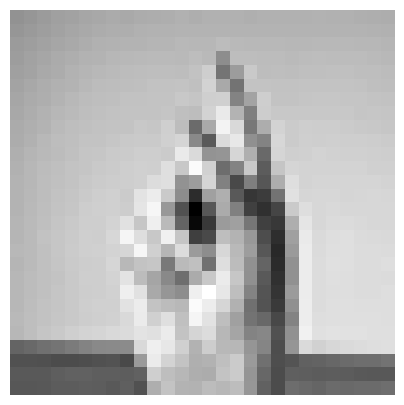

In [12]:
# Select a random index from the test set
rnd_idx = np.random.randint(len(y_test)) # Generate a random integer between 0 and the length of y_test

# Assign the labels from the dataset
label_to_sign = {0: 'A',
                 1: 'B',
                 2: 'C',
                 3: 'D',
                 4: 'E',
                 5: 'F',
                 6: 'G',
                 7: 'H',
                 8: 'I',
                 9: 'K',
                 10: 'L',
                 11: 'M',
                 12: 'N',
                 13: 'O',
                 14: 'P',
                 15: 'Q',
                 16: 'R',
                 17: 'S',
                 18: 'T',
                 19: 'U',
                 20: 'V',
                 21: 'W',
                 22: 'X',
                 23: 'Y',
                 24: 'Y'}  # Excluding 'J' and 'Z'
print(f'The image represents the sign: {label_to_sign[y_test[rnd_idx]]}')
print(f'The value represents the sign: {y_test[rnd_idx]}')

# Reshape and plot the selected test image
plot_number(x_test[rnd_idx].reshape(28,28))

### Equations provided for our model

$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$


$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$

$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$

$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

#### Create mini batches

The following section divides the section into smaller subsets called **mini-batches.**

They make the training process faster and more effective at learning from the dataset.

In [13]:
def create_minibatches(mb_size, x, y, shuffle=True):
    '''
    Creates minibatches from the dataset.

    Parameters:
        mb_size (int): The size of each minibatch.
        x (np.ndarray): Input data of shape (num_samples, num_features).
        y (np.ndarray): Labels of shape (num_samples) from the input data.
        shuffle (bool): Whether to shuffle the data before creating minibatches. Default is True.
    '''
    assert x.shape[0] == y.shape[0], 'Mismatch minibatch size'

    # Total number of samples in the dataset
    total_data = x.shape[0]

    if shuffle:
      # Create an array of indices [0, 1, 2, ..., total_data-1]
      idxs = np.arange(total_data)
      # Randomly shuffle the indices to randomize the order of the data
      np.random.shuffle(idxs)
      # Reorder `x` based on the shuffled indices
      x = x[idxs]
      # Reorder `y` based on the shuffled indices
      y = y[idxs]

    # Generate minibatches by iterating through the data in steps of `mb_size`
    for i in range(0, total_data, mb_size):
      yield x[i:i + mb_size], y[i:i + mb_size]

## Linear, ReLU, and Sequential Classes

In [14]:
# Generate attributes to the parameters using the below class
"""
(np.ndarray): This indicates that the new class ´np_tensor´ inherits from the ´np.ndarray´ class.
´np.ndarray´ is the core class in the NumPy library representing multi-dimensional arrays.
By inheriting from ´np.darray´, ´np_tensor´ gets all the functionality of NumPy arrays.
"""

class np_tensor(np.ndarray): pass

###  Linear Class

$$z^1 = W^1 X + b^1$$



In [15]:
class Linear():
    def __init__(self, input_size, output_size):
        '''
        Init parameters using Kaiming He initialization

        Parameters:
          self: instance of the class.
          input_size: number of input features (from previous layer)
          output_size: number of output features (to the next layer)
        Atributes:
          self.W (np.ndarray): Weight matrix of shape (output_size, input_size)
          self.b (np.ndarray): Bias vector of shape (output_size, 1)
        '''

      # Initialize the weights using Kaiming He initialization
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor) # Scale weights by 1/sqrt(input_size / 2) for better gradient flow in deep networks
      # Initialize the biases to zero
        self.b = (np.zeros((output_size, 1))).view(np_tensor)


    def __call__(self, X): # lineal class forward
        '''
        Performs the forward pass of the linear layer.

        Parameters:
          X (np.ndarray): Input data of shape, (input_size, batch_size), where batch_size is the number of samples.
        Returns:
          Z (np.ndarray): Output of the linear transformation (output size, batch_size) - computed as Z= W @ X + b).

        '''
        # Forward pass
        Z = self.W @ X + self.b
        return Z


    def backward(self, X, Z):
        '''
        Performs the backward pass of the linear layer.

        Parameters:
          X (np.ndarray): Input data from the forward pass, (input_size, batch_size).
          Z (np.ndarray): Output from the forward pass (contains the gradients as `Z.grad`).
        '''
        # Compute the gradient of the input (backpropagate through the weights)
        X.grad = self.W.T @ Z.grad

        # Compute the gradient of the weights
        self.W.grad = Z.grad @ X.T

        # Compute the gradient of the biases (sum the gradients over all samples)
        self.b.grad = np.sum(Z.grad, axis=1, keepdims=True)

### ReLU Class

In the following section, we apply the ReLU activation function to the input data (input data coming from the activation function of the previous layer).

$$a^1 = ReLU(z^1) $$

In [16]:
class ReLU():
    def __call__(self, Z):
        '''
        Forward pass of the ReLU activation function

        Parameters:
          Z (np.ndarray): Input to the activation function (e.g., output from a linear layer)
        Returns:
          np.ndarray: Element-wise maximum between 0 and Z
        '''

        # Apply ReLU: If Z > 0, keep Z; otherwise, set to 0
        return np.maximum(0, Z)

    def backward(self, Z, A):
        '''
        Backward pass of the ReLU activation function.

        Parameters:
          Z (np.ndarray): Input to the ReLU during the forward pass.
          A (np.ndarray): Output of the ReLU during the forward pass, containing gradients from the next layer.
        '''

        # Copy the gradient from the next layer
        Z.grad = A.grad.copy()

        # Set gradients to zero for elements where Z <= 0
        Z.grad[Z <= 0] = 0


### Sequential Class

In [17]:
class Sequential_layers():
    def __init__(self, layers):
        '''
        Initializes the Sequential layers object with a list of layers

        Parameters:
          layers (list): A list of layer objects.
        Atributes:
          self.layers (list)
          self.x (np.ndarray)
          self.outputs (dict)
        '''

        # Store the list of layers
        self.layers = layers
        # Placeholder Input/output during forward pass
        self.x = None
        # Dictionary to save the outputs
        self.outputs = {}


    def __call__(self, X):
        '''
        Performs the forward pass through all layers sequentially

        Parameters:
          X (np.ndarray): The input to the network, (input_size, batch_size)
        Returns:
          np.ndarray: The final output of the network
        '''

        # Save the input to the first layer
        self.x = X
        # Store the initial input as '10'
        self.outputs['l0'] = self.x

        # Pass the input through each layer in sequence
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)
            self.outputs['l'+str(i)]=self.x
        return self.x


    def backward(self):
      '''
      Backward pass through all layers in reverse order
      '''
      # Iterate through layers in reverse order for backpropagation
      for i in reversed(range(len(self.layers))):
      # Pass the current and next layer outputs to the layer's backward method
          self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])

    def update(self, learning_rate = 1e-3):
      '''
      Updates the weights and biases of all layers
      Parameters:
        learning_rate (float): The learning rate used for weight updates.
      '''
      for layer in self.layers:
        # Skip ReLu layers since they have no parameters to update
          if isinstance(layer, ReLU): continue
          # Update using their gradients
          layer.W = layer.W - learning_rate * layer.W.grad
          layer.b = layer.b - learning_rate * layer.b.grad

    def predict(self, X):
      '''
      Forward pass and returns the predicted class for each sample
      Parameters:
        X (np.ndarray): The input to the network, (input_size, batch_size)
      Returns:
        np.ndarray: The predicted class for each sample
      '''
      # Return the class with the highest score
      return np.argmax(self.__call__(X))

### Cost Function

In [18]:
def softmaxXEntropy(x, y):
    '''
    Computes the softmax activation, cross-entropy loss, and the gradient of the loss

    Parameters:
      x (np.ndarray): The logits (raw scores) for each class, (num_classes, batch_size)
      y (np.ndarray): The `y` labels, (batch_size,)

    Returns:
      preds (np.ndarray): The predicted probabilities for each class, (num_classes, batch_size)
      cost (float): The average cross-entropy loss over the batch
    '''

    # Get the batch size (number of samples in the batch)
    batch_size = x.shape[1]

    # Compute the softmax probabilities

    # Exponentiate the logits for each class
    exp_scores = np.exp(x)
    # Normalize to get probabilities per sample
    probs = exp_scores / exp_scores.sum(axis=0)
    # Save the probabilities for predictions
    preds = probs.copy()

    # Convert `y` labels to integers
    y = y.astype(int)

    # Handle cases where y might have out-of-bounds indices (e.g., due to data corruption)
    valid_indices = np.clip(y.squeeze(), 0, probs.shape[0] - 1)  # Ensure indices are within [0, num_classes-1]

    # Extract the predicted probabilities for the correct classes
    y_hat = probs[valid_indices, np.arange(batch_size)]

    # Compute the cross-entropy loss
    cost = np.sum(-np.log(y_hat)) / batch_size

    # Backpropagation: Compute the gradient of the loss w.r.t. logits
    probs[valid_indices, np.arange(batch_size)] -= 1
    # Save the gradient of the loss w.r.t. the input `x`
    x.grad = probs.copy()

    return preds, cost

### Training loop

In [19]:
def train(model, epochs, mb_size=128, learning_rate = 1e-3):
  '''
  Trains the model over a specific number of epochs.

  Parameters:
    model: The neural network model to be trained (e.g., Sequential_layers instance).
    epochs (int): The number of times the entire training dataset is processed.
    mb_size (int): The size of each mini-batch. Default is 128.
    learning_rate (float): The step size for updating model parameters. Default is 1e-3.
  '''
  # Loop through the number of epochs
  for epoch in range(epochs):
    # Iterate through the training data in mini-batches
    for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
      # Forward pass through the model
      # Transpose `x` to match the expected shape
      scores = model(x.T.view(np_tensor))

      # Softmax and cross-entropy loss
      _, cost = softmaxXEntropy(scores, y)

      # Backward pass to compute gradients
      model.backward()

      # Update parameters using the computed gradients
      model.update(learning_rate)

    # Using this condition to avoid printing all the epochs
    if epoch % 10 == 0:
      print(f'Epoch: {epoch} | Cost: {cost:.4f} | Accuracy: {accuracy(x_val, y_val, mb_size):.3f}')

### Create and train the model

In [20]:
def accuracy(x, y, mb_size):
  '''
  Accuracy of the model

  Parameters:
    x (np.ndarray): The input to the network, (input_size, batch_size)
    y (np.ndarray): The `y` labels, (batch_size,)
    mb_size (int): The size of each mini-batch.

  Returns:
    float: The accuracy of the model on the given data.
  '''
  # Counter of the correct predictions
  correct = 0
  # Counter of total number of samples
  total = 0


  # Iterate over the dataset in mini-batches
  for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):
      # Forward pass to get the predictions
      # Transpose to match model expectations
      pred = model(x.T.view(np_tensor))

      # Compare the predicted class to the true class
      correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())

      # Update the total number of samples processed
      total += pred.shape[1]
  return correct/total

In [21]:
# Model initialization
model = Sequential_layers([
    Linear(784, 200), # 784 features, 200 neurons
    ReLU(),           # Activation function
    Linear(200, 200), # Hidden layer: 200 neurons to another 200 neurons
    ReLU(),           # Activation function
    Linear(200, 24)   # Output layer: 200 neurons, 24 classes
])

# Training
mb_size = 512         # mini-batch size
learning_rate = 1e-4  # learning rate for gradient descent
epochs = 100          # number of training epochs

In [22]:
train(model, epochs, mb_size, learning_rate)

Epoch: 0 | Cost: 1.1389 | Accuracy: 0.553
Epoch: 10 | Cost: 0.0390 | Accuracy: 0.745
Epoch: 20 | Cost: 0.0138 | Accuracy: 0.759
Epoch: 30 | Cost: 0.0084 | Accuracy: 0.762
Epoch: 40 | Cost: 0.0064 | Accuracy: 0.760
Epoch: 50 | Cost: 0.0042 | Accuracy: 0.760
Epoch: 60 | Cost: 0.0035 | Accuracy: 0.759
Epoch: 70 | Cost: 0.0026 | Accuracy: 0.757
Epoch: 80 | Cost: 0.0022 | Accuracy: 0.758
Epoch: 90 | Cost: 0.0019 | Accuracy: 0.759


### Test your model on Random data from your test set

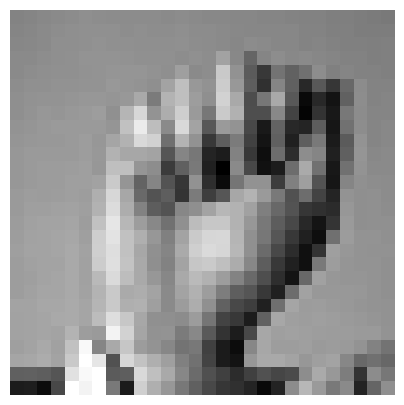

Predicted sign: a | Actual sign: a


In [24]:
# Select a random index from the test set
idx = np.random.randint(len(y_test))

# Plot the image
# Reshape the test sample from a 1D array (784,) to a 2D grid (28x28) for visualization.
plot_number(x_test[idx].reshape(28,28))

# Predict the class for the selected test image
# Reshape the image to a column vector (784, 1) to match the model's input shape.
pred = model.predict(x_test[idx].reshape(-1, 1))

# Print the result
print(f'Predicted sign: {alphabet[pred]} | Actual sign: {alphabet[y_test[idx]]}')